In [2]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

import glob
import matplotlib.pyplot as plt
import numpy as np

22/03/03 06:51:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.functions import *
from pyspark.sql.functions import split, explode

In [3]:
def plot_netcount_results(file, title):
    bpftrace_netcount_pattern = r'^@(\w+)\[(.+)\]\D*(\d+)'
    stl_dns_streams_netcount_file = glob.glob(file)
    stl_dns_streams_netcount_df = spark.read.text(stl_dns_streams_netcount_file)

    bpftrace_cs_df = stl_dns_streams_netcount_df.select(
                                regexp_extract('value', bpftrace_netcount_pattern, 1).alias('action'),
                                regexp_extract('value', bpftrace_netcount_pattern, 2).alias('device'), 
                                regexp_extract('value', bpftrace_netcount_pattern, 3).cast('integer').alias('packets'),                               
                    ).filter(' action != ""').withColumn("order", monotonically_increasing_id())
    
    uniq_names = ['nic_recv_count', 'nic_send_count']
    tables = [bpftrace_cs_df.where(bpftrace_cs_df.action == x) for x in uniq_names]

    list_tables = []
    uniq_devices = ['enP39834s2', 'enP45535s3', 'eth1', 'eth2']
    fig, axs = plt.subplots(1, 2, figsize=(21,6))
    fig.suptitle(title)
    for ti, table in enumerate(tables):
        list_tables = [table.where(table.device == x) for x in uniq_devices]
        for i, t in enumerate(list_tables):
            df = t.toPandas()
            axs[ti] = df.plot(ax=axs[ti], kind='line', x='order', y='packets', label="{} {}".format(uniq_names[ti], uniq_devices[i])) #
        axs[ti].set_title(uniq_names[ti])

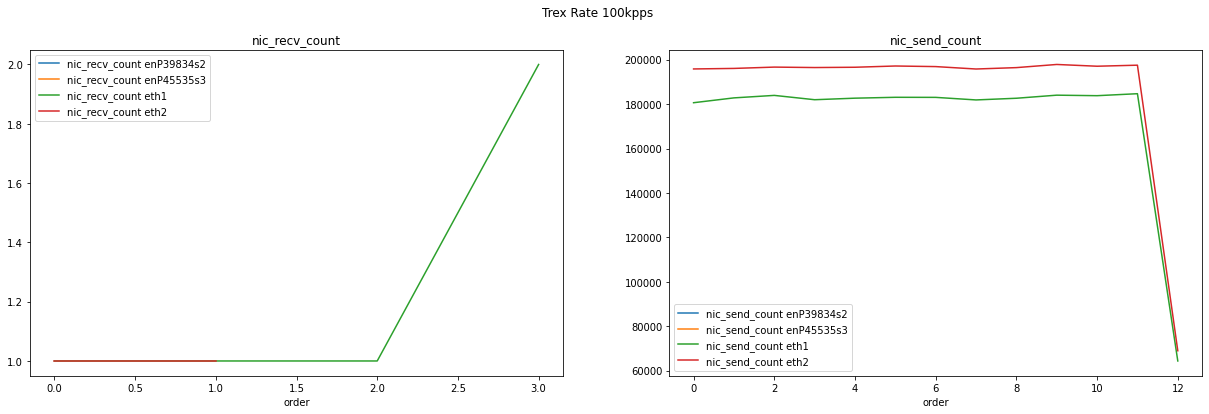

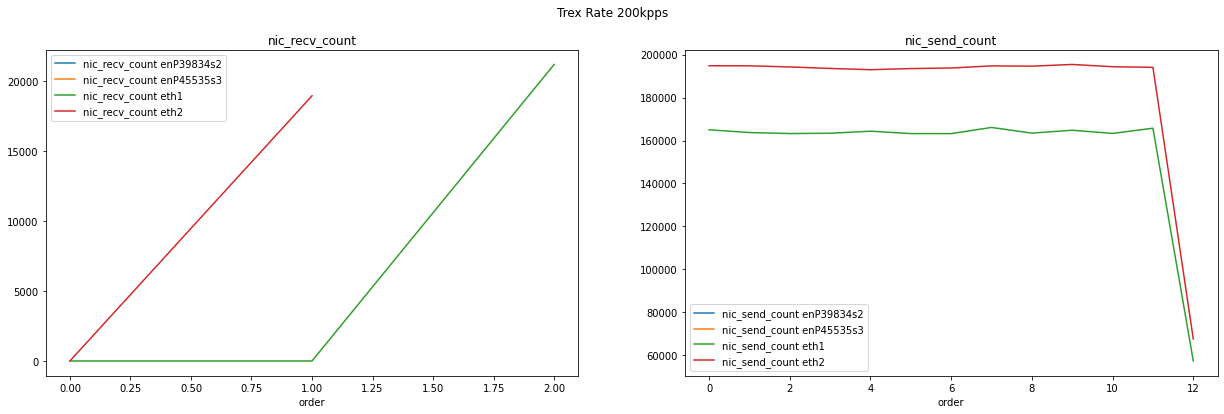

In [10]:
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_100kpps-netcount.bt', 'Trex Rate 100kpps')
plot_netcount_results('../ansible/.results/stl_dns_streams-rate_200kpps-netcount.bt', 'Trex Rate 200kpps')

In [6]:
def plot_netsize_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)\[(.+)\]'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 2).alias('device'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_action_df = bpftrace_sz_df.select("device", "action").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_action_df)

    netsize_sum_df = bpftrace_sz_df.groupBy("action", "device", "range").agg(sum('number').alias('sum_number'))


    joined_df = unique_comb_df.join(netsize_sum_df,["action", "device", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number'))

    uniq_names = ['nic_send_bytes', 'nic_recv_bytes', 'send_bytes', 'recv_bytes']
    tables = [joined_df.where(joined_df.action == x) for x in uniq_names]
    uniq_devices = ['enP39834s2', 'enP45535s3', 'eth1', 'eth2']

    fig, axs = plt.subplots(1, 4, figsize=(21,6))
    fig.suptitle(title)
    for ti, table in enumerate(tables):
        # create order column corresponding to range
        table = table.withColumn('order', regexp_replace('range', 'K', '000'))
        table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
        list_tables = [table.where(table.device == x).orderBy('order').withColumn('mag', col('range') ) for x in uniq_devices]
        for i, t in enumerate(list_tables):
            df = t.toPandas()
            axs[ti] = df.plot(ax=axs[ti], kind='line', x='range', y='number', label="{} {}".format(uniq_names[ti], uniq_devices[i])) #
            # axs[i].set_ylim([0, 4e8])
        axs[ti].set_title(uniq_names[ti])

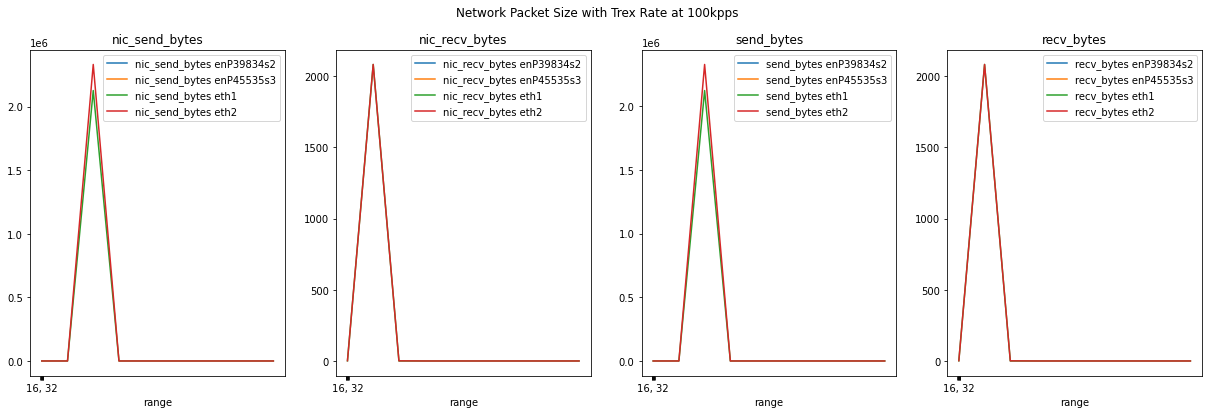

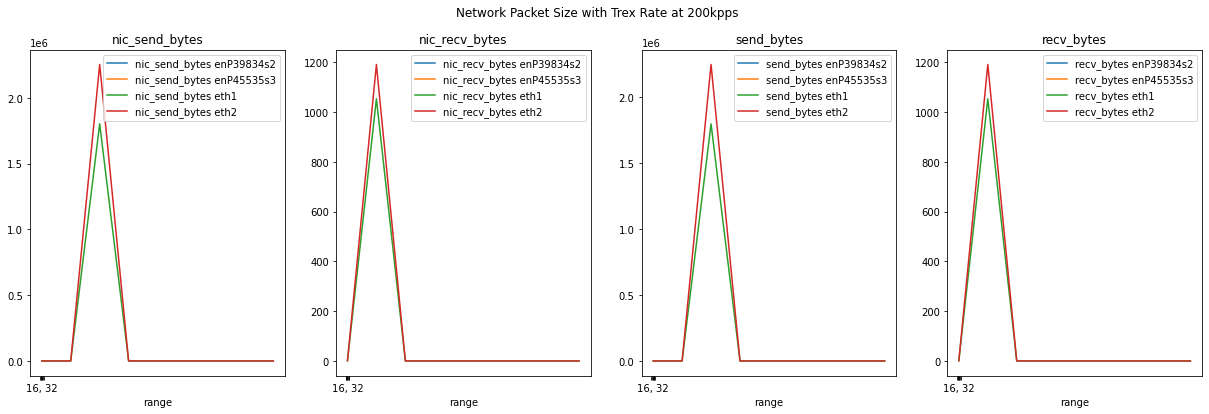

In [9]:
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_100kpps-netsize.bt', 'Network Packet Size with Trex Rate at 100kpps')
plot_netsize_results('../ansible/.results/stl_dns_streams-rate_200kpps-netsize.bt', 'Network Packet Size with Trex Rate at 200kpps')

In [11]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_trex_results(file, title):
    stl_dns_streams_trex_file = glob.glob(file)
    stl_dns_streams_trex_df = spark.read.json(stl_dns_streams_trex_file)

    trex_df = stl_dns_streams_trex_df.select('stats.0', 'stats.1', 'stats.global')

    formated_0_df = trex_df.select(explode(trex_df['0']).alias('port_0')).withColumn('port', lit('0'))
    formated_1_df = trex_df.select(explode(trex_df['1']).alias('port_1')).withColumn('port', lit('1'))

    trex_port_0 = formated_0_df.select('port', 'port_0.ibytes', 'port_0.obytes', 'port_0.ipackets', 'port_0.opackets', 'port_0.tx_util').withColumn("id", monotonically_increasing_id())

    trex_port_1 = formated_1_df.select('port', 'port_1.ibytes', 'port_1.obytes', 'port_1.ipackets', 'port_1.opackets', 'port_1.tx_util').withColumn("id", monotonically_increasing_id())

    ports = ['0', '1']
    uniq_plots = ['ibytes', 'obytes', 'ipackets', 'opackets', 'tx_util']


    figsize = (15, 11)
    cols = 3
    rows = 3
    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, 5) # 5 is the actual number of plots/datasets
    yrange = [[0, 4e9], [0, 4e9], [0, 5e7], [0, 5e7], [0, 100]]

    tables = [trex_port_0, trex_port_1]
    for ti, table in enumerate(tables):
        for i, p in enumerate(uniq_plots):
            df = table.toPandas()
            axs[i] = df.plot(ax=axs[i], kind='line', x='id', y=p, label="Port {}".format(ports[ti])) #
            axs[i].set_title(uniq_plots[i])
            # axs[i].set_
            axs[i].set_ylim(yrange[i])
    
    # for ti, table in enumerate(tables):
    #     for i, p in enumerate(uniq_plots):
    #         df = table.toPandas()
    #         axs[i] = df.plot(ax=axs[i], kind='line', x='id', y=p, label="Port {}".format(ports[ti])) #
    #         axs[i].set_title(uniq_plots[i])


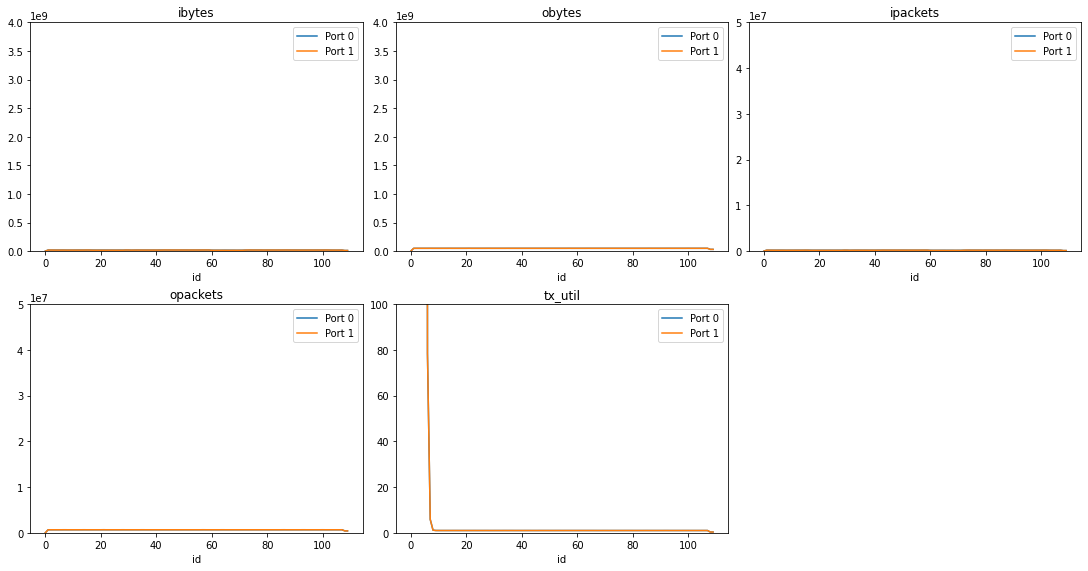

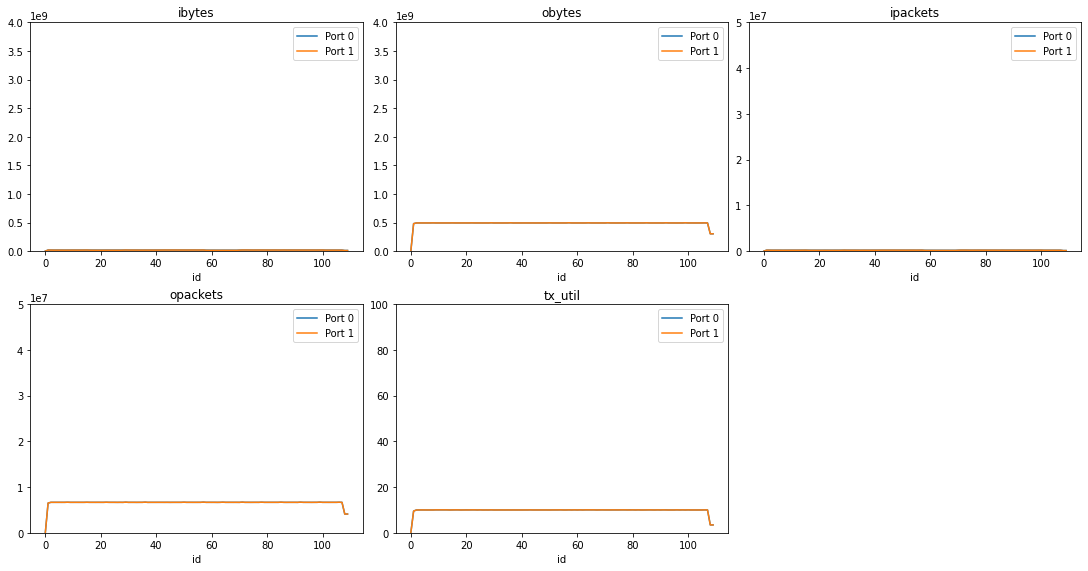

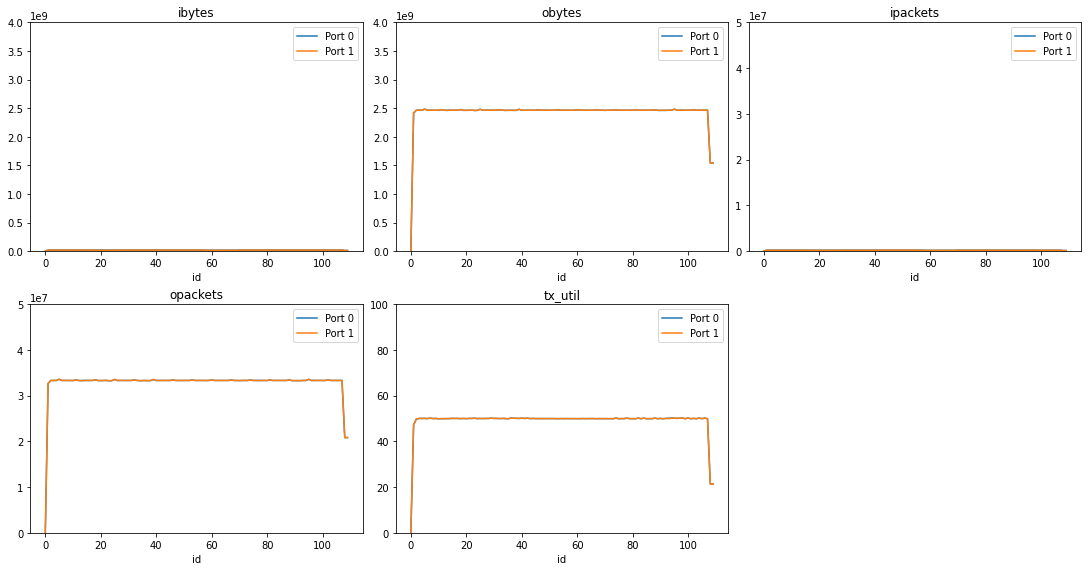

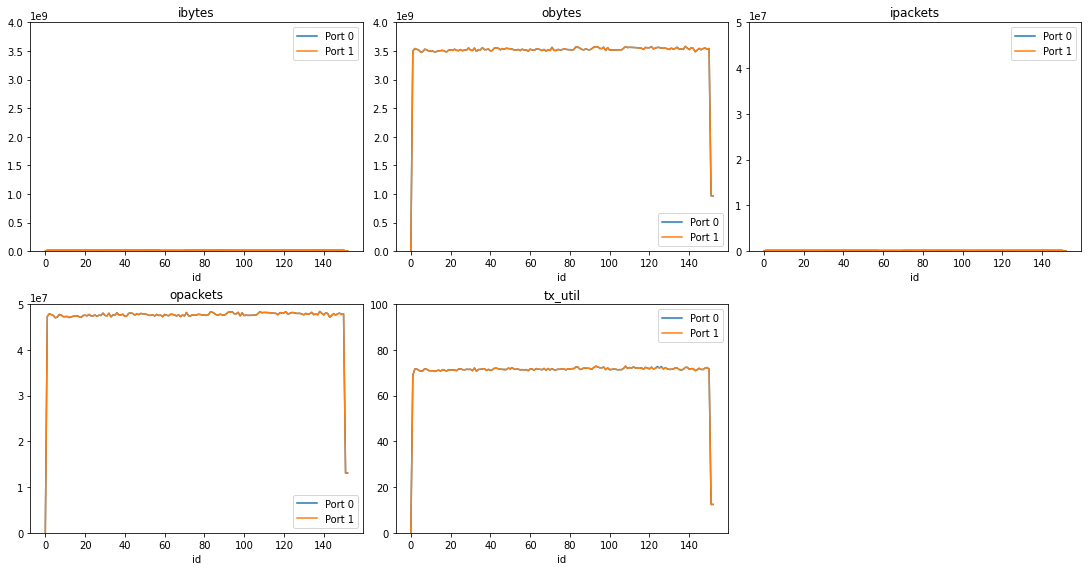

In [8]:
plot_trex_results('../ansible/.results/stl_dns_streams-rate_1-trex.json', 'Trex Rate at 1% Line rate')
plot_trex_results('../ansible/.results/stl_dns_streams-rate_10-trex.json', 'Trex Rate at 10% Line rate')
plot_trex_results('../ansible/.results/stl_dns_streams-rate_50-trex.json', 'Trex Rate at 50% Line rate')
plot_trex_results('../ansible/.results/stl_dns_streams-rate_100-trex.json', 'Trex Rate at 100% Line rate')

In [13]:
def plot_nettxlat_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)\[(.+)\]'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 2).alias('device'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_df = bpftrace_sz_df.select("device").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_df)
    
    nettxlat_sum_df = bpftrace_sz_df.groupBy("device", "range").agg(sum('number').alias('sum_number'))

    joined_df = unique_comb_df.join(nettxlat_sum_df,["device", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number')).select('*').where(col('device') != "")
    
    uniq_devices = ['enP39834s2', 'enP45535s3']

    fig, ax = plt.subplots()
    
    fig.suptitle(title)
    # for ti, table in enumerate(tables):
        # create order column corresponding to range
    table = joined_df.withColumn('order', regexp_replace('range', 'K', '000'))
    table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
    list_tables = [table.where(table.device == x).orderBy('order').withColumn('mag', col('range') ) for x in uniq_devices]
    for i, t in enumerate(list_tables):
        df = t.toPandas()
        ax = df.plot(ax=ax, kind='line', x='range', y='number', label="nettxlat {}".format(uniq_devices[i])) #

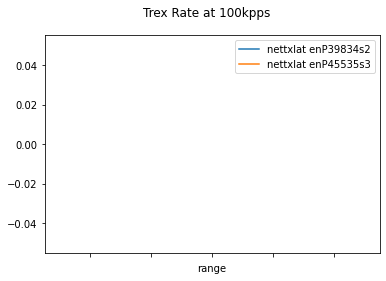

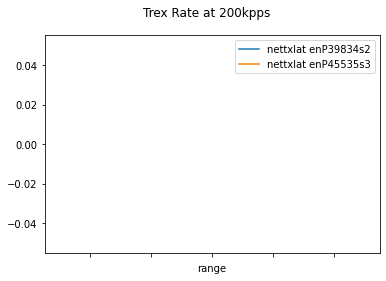

In [15]:
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_100kpps-nettxlat-dev.bt', 'Trex Rate at 100kpps')
plot_nettxlat_results('../ansible/.results/stl_dns_streams-rate_200kpps-nettxlat-dev.bt', 'Trex Rate at 200kpps')

In [16]:
def plot_runqlat_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_df = bpftrace_sz_df.select("action").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_df)
    
    nettxlat_sum_df = bpftrace_sz_df.groupBy("action", "range").agg(sum('number').alias('sum_number'))

    joined_df = unique_comb_df.join(nettxlat_sum_df,["action", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number')).select('*').where(col('action') != "")
    
    tables = [joined_df]

    fig, ax = plt.subplots()
    
    fig.suptitle(title)
        # create order column corresponding to range
    table = joined_df.withColumn('order', regexp_replace('range', 'K', '000'))
    table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
    table = table.orderBy('order')
    
    df = table.toPandas()
    ax = df.plot(ax=ax, kind='line', x='range', y='number', label="runqlat") #

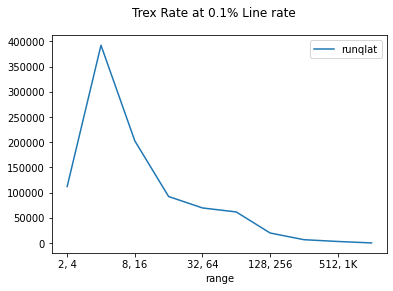

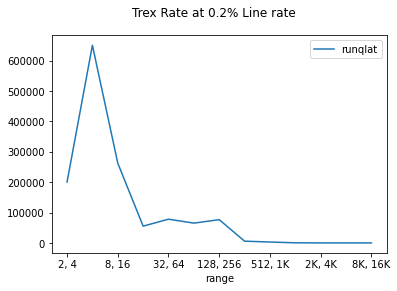

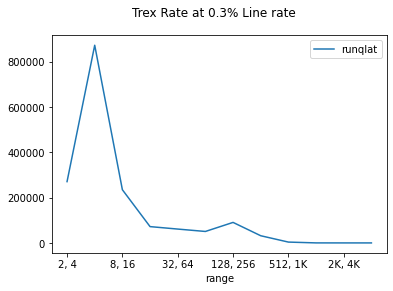

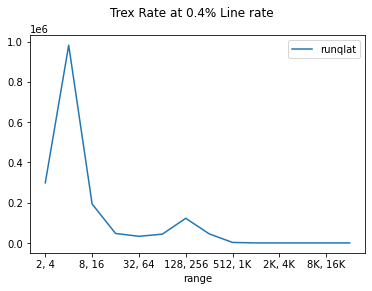

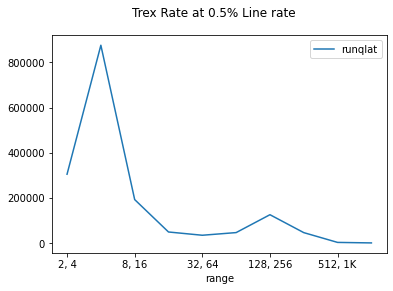

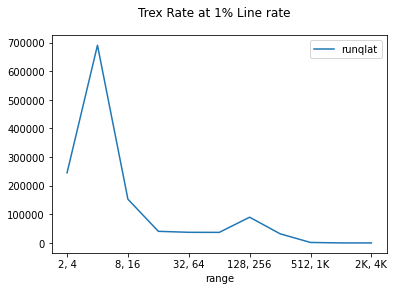

In [16]:
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_100kpps-runqlat.bt', 'Trex Rate at ')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.2-runqlat.bt', 'Trex Rate at 0.2% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.3-runqlat.bt', 'Trex Rate at 0.3% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.4-runqlat.bt', 'Trex Rate at 0.4% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_0.5-runqlat.bt', 'Trex Rate at 0.5% Line rate')
plot_runqlat_results('../ansible/.results/stl_dns_streams-rate_1-runqlat.bt', 'Trex Rate at 1% Line rate')

In [17]:
def plot_skblife_results(file, title):
    bpftrace_netsize_pattern = r'\[(.+)\)\D*(\d+)'
    bpftrace_netsize_hdr_pattern = r'@(\w+)'
    stl_dns_streams_netsize_file = glob.glob(file)

    # Create df for histogram stats, each historgram from bpftrace is seperated by \n\n
    df2 = spark.read.text(stl_dns_streams_netsize_file, lineSep="\n\n")

    # The label of the historgram and values are seperated by :
    df3 = df2.select('value').withColumn('Type', split(df2['value'], ':').getItem(0)).withColumn('Result', split(df2['value'], ':').getItem(1))

    # The histogram bars are seperated by \n
    df4 = df3.withColumn('Result',explode(split('Result','\n')))

    # Extract the actions, device names, x-axis range and the value (number)
    bpftrace_sz_df = df4.select(
                                col('Type'),
                                regexp_extract('Type', bpftrace_netsize_hdr_pattern, 1).alias('action'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 1).alias('range'),
                                regexp_extract('Result', bpftrace_netsize_pattern, 2).cast('integer').alias('number'),                               
    ).dropna()

    distinct_range_df = bpftrace_sz_df.select("range").distinct()
    distinct_device_df = bpftrace_sz_df.select("action").distinct()
    unique_comb_df = distinct_range_df.crossJoin(distinct_device_df)
    
    nettxlat_sum_df = bpftrace_sz_df.groupBy("action", "range").agg(sum('number').alias('sum_number'))

    joined_df = unique_comb_df.join(nettxlat_sum_df,["action", "range"],"full").withColumn('number',  when(col("sum_number") > 0, col("sum_number")).otherwise(0)).drop(col('sum_number')).select('*').where(col('action') != "")


    fig, ax = plt.subplots()
    
    fig.suptitle(title)
    
    table = joined_df.withColumn('order', lit(0))
    table = table.withColumn('order',  when(split(table['range'], ',').getItem(0).contains('K'), regexp_replace('range', 'K', '000')).otherwise(col('order')))
    table = table.withColumn('order',  when(split(table['range'], ',').getItem(0).contains('M'), regexp_replace('range', 'M', '000000')).otherwise(col('order')))
    table = table.withColumn('order',  when(split(table['range'], ',').getItem(0).contains('G'), regexp_replace('range', 'G', '000000000')).otherwise(col('order')))
    table = table.withColumn('order', split(table['order'], ',').getItem(0).cast('int'))
    table = table.orderBy('order')

    df = table.toPandas()
    ax = df.plot(ax=ax, kind='line', x='range', y='number', label="skb_residency_nsecs")

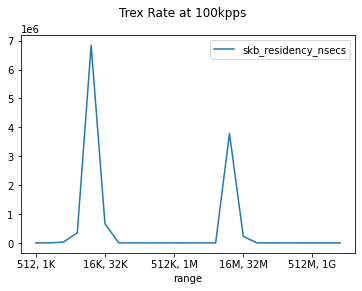

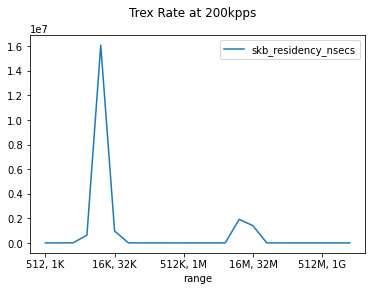

In [18]:
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_100kpps-skblife.bt', 'Trex Rate at 100kpps')
plot_skblife_results('../ansible/.results/stl_dns_streams-rate_200kpps-skblife.bt', 'Trex Rate at 200kpps')

In [34]:
def plot_cachestat_results(file, title):
    stl_dns_streams_cachestat_file = glob.glob(file)
    stl_dns_streams_cachestat_df = spark.read.json(stl_dns_streams_cachestat_file)

    ordered_df = stl_dns_streams_cachestat_df.withColumn("order", monotonically_increasing_id())

    uniq_plots = ['BUFFERS_MB', 'CACHED_MB', 'DIRTIES', 'HITRATIO', 'HITS', 'MISSES']


    figsize = (15, 11)
    cols = 3
    rows = 2
    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    axs = trim_axs(axs, 6) # 5 is the actual number of plots/datasets

    for i, c in enumerate(uniq_plots):
        df = ordered_df.toPandas()
        axs[i] = df.plot(ax=axs[i], kind='bar', x='order', y=c, label=c) #
        axs[i].set_title(title)


Examine the page cache hit ratio over time. does any other workload perturb the hit ratio, or does any tuning improve it?


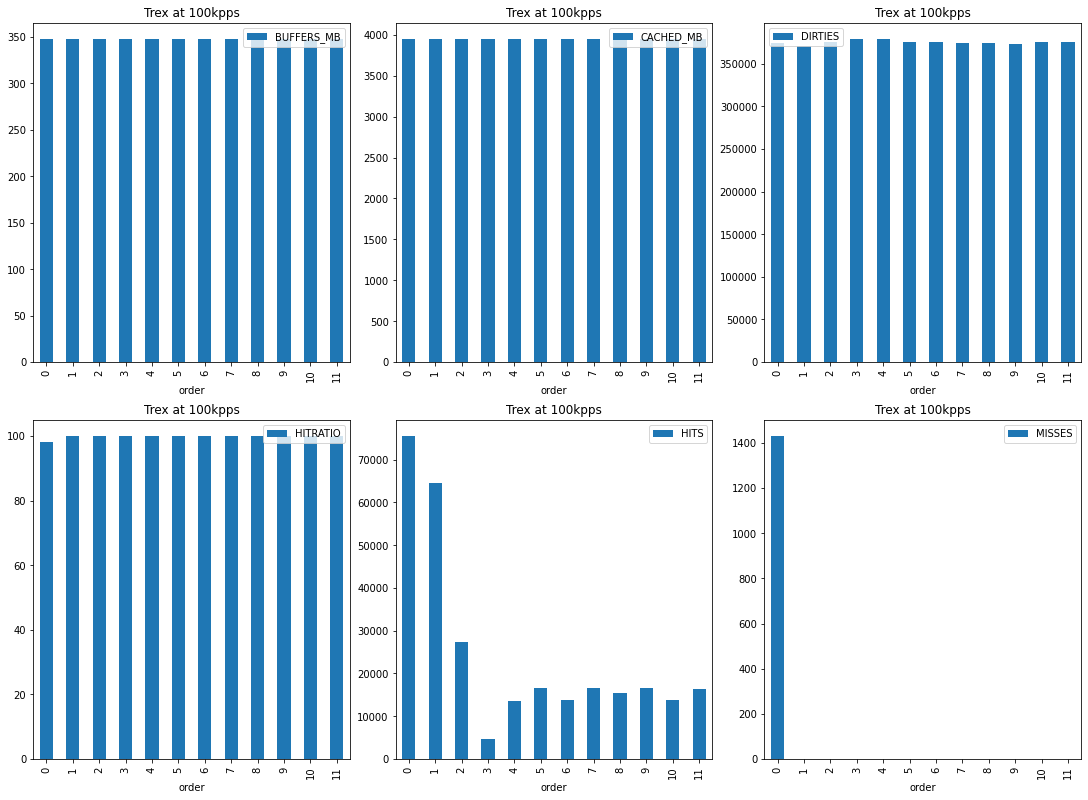

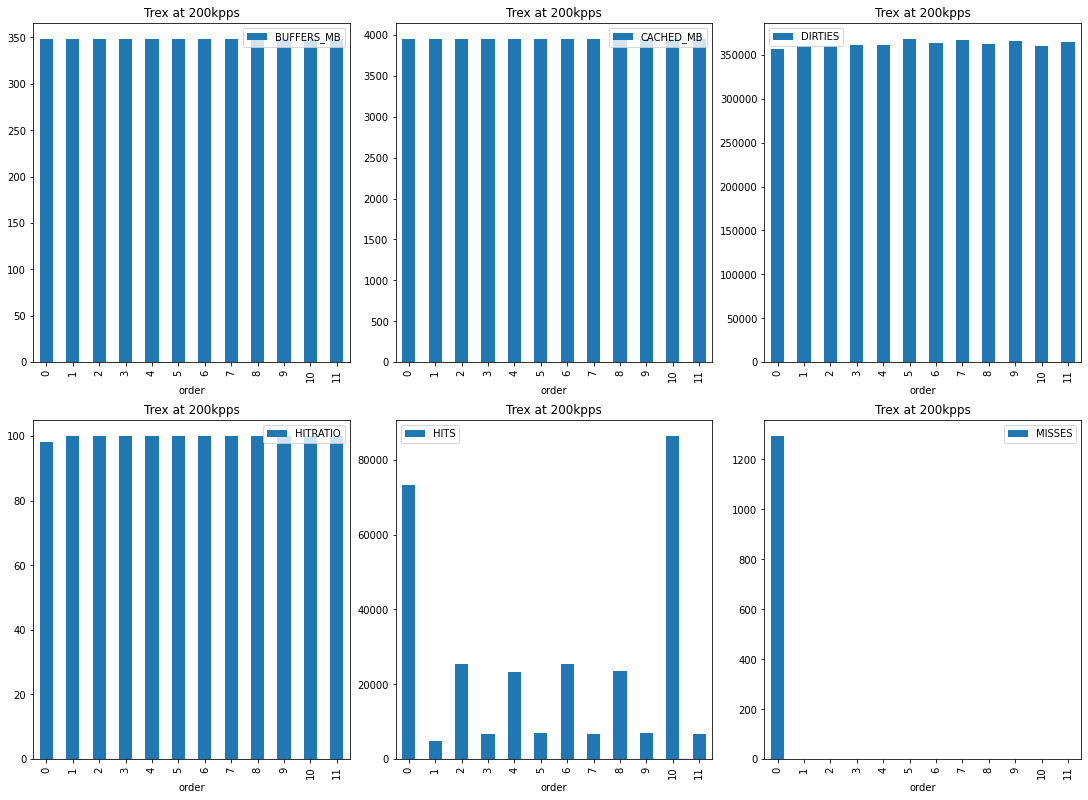

In [38]:
print("Examine the page cache hit ratio over time. does any other workload perturb the hit ratio, or does any tuning improve it?")
plot_cachestat_results("../ansible/.results/stl_dns_streams-rate_100kpps-cachestat.py.out", "Trex at 100kpps")
plot_cachestat_results("../ansible/.results/stl_dns_streams-rate_200kpps-cachestat.py.out", "Trex at 200kpps")

In [58]:
def plot_filetop_results(file, title):
    stl_dns_streams_filetop_file = glob.glob(file)
    stl_dns_streams_filetop_df = spark.read.json(stl_dns_streams_filetop_file)

    grouped_writes_df = stl_dns_streams_filetop_df.groupBy('FILE').agg({'WRITES': 'sum', 'READS': 'sum' })
    grouped_writes_df.show()

In [59]:
plot_filetop_results("../ansible/.results/stl_dns_streams-rate_100kpps-filetop.py.out", "Trex at 100kpps")
plot_filetop_results("../ansible/.results/stl_dns_streams-rate_200kpps-filetop.py.out", "Trex at 200kpps")

+--------------------+----------+-----------+
|                FILE|sum(READS)|sum(WRITES)|
+--------------------+----------+-----------+
|ansible_ansible.l...|       516|         12|
|                wtmp|     16770|          0|
|               group|        85|          0|
|             cmdline|        60|          0|
|AnsiballZ_async_s...|       222|         24|
|           named.log|         0|    4381152|
|             .bashrc|         2|          0|
|                stat|         2|          0|
|                 TCP|       417|        206|
|          login.defs|        95|          0|
|             loadavg|        12|          0|
|            loginuid|         2|          0|
|           protocols|         1|          0|
|             timeout|         8|          0|
|              status|         1|          0|
|              shells|       300|          0|
|              cgroup|         2|          0|
|         .kvp_pool_1|       634|          0|
|           sessionid|         2| 

In [72]:
def plot_hardirqs_results(file, title):
    stl_dns_streams_hardirqs_file = glob.glob(file)
    stl_dns_streams_hardirqs_df = spark.read.json(stl_dns_streams_hardirqs_file)

    grouped_writes_df = stl_dns_streams_hardirqs_df.groupBy('hardirq').agg({'count': 'sum' })
    grouped_writes_df.show()

In [73]:
plot_hardirqs_results("../ansible/.results/stl_dns_streams-rate_100kpps-hardirqs.py.count.out", "Trex at 100kpps")
plot_hardirqs_results("../ansible/.results/stl_dns_streams-rate_200kpps-hardirqs.py.count.out", "Trex at 200kpps")

+--------------------+------------------+
|             hardirq|        sum(count)|
+--------------------+------------------+
|mlx5_comp7@pci:42...|        218703.209|
|mlx5_comp0@pci:4d...|        230000.439|
|mlx5_comp2@pci:42...|490855.13599999994|
|mlx5_async@pci:4d...|28614.144999999997|
|            ata_piix|         15327.071|
|mlx5_comp12@pci:4...|        384441.971|
|mlx5_async@pci:42...|26737.419000000005|
+--------------------+------------------+

+--------------------+------------------+
|             hardirq|        sum(count)|
+--------------------+------------------+
|mlx5_comp7@pci:42...|194316.95999999996|
|mlx5_comp0@pci:4d...|235151.28100000002|
|mlx5_comp0@pci:42...|               5.5|
|mlx5_comp2@pci:42...|        444607.293|
|mlx5_async@pci:4d...|         33786.006|
|            ata_piix|         15723.198|
|mlx5_comp12@pci:4...|        323390.597|
|mlx5_async@pci:42...|         18372.624|
+--------------------+------------------+



In [76]:
def plot_softirqs_results(file, title):
    stl_dns_streams_softirqs_file = glob.glob(file)
    stl_dns_streams_softirqs_df = spark.read.json(stl_dns_streams_softirqs_file)

    grouped_writes_df = stl_dns_streams_softirqs_df.groupBy('softirq').agg({'count': 'sum' })
    grouped_writes_df.show()

In [77]:
plot_softirqs_results("../ansible/.results/stl_dns_streams-rate_100kpps-softirqs.py.count.out", "Trex at 100kpps")
plot_softirqs_results("../ansible/.results/stl_dns_streams-rate_200kpps-softirqs.py.count.out", "Trex at 200kpps")

+-------+--------------------+
|softirq|          sum(count)|
+-------+--------------------+
|  timer|            19300.32|
| net_rx|2.2146903110999998E7|
|    rcu|           19705.717|
|  block|  10986.865999999998|
|  sched|  180577.49899999998|
| net_tx|  241.90200000000002|
|tasklet|          349463.458|
+-------+--------------------+

+-------+--------------------+
|softirq|          sum(count)|
+-------+--------------------+
|  timer|           18857.916|
| net_rx|3.1346583898000002E7|
|    rcu|  19579.232000000004|
|  block|           10267.279|
|  sched|          179903.204|
| net_tx|             240.302|
|tasklet|          308122.157|
+-------+--------------------+



In [78]:
def plot_syscount_results(file, title):
    stl_dns_streams_softirqs_file = glob.glob(file)
    stl_dns_streams_softirqs_df = spark.read.json(stl_dns_streams_softirqs_file)

    grouped_writes_df = stl_dns_streams_softirqs_df.groupBy('SYSCALL').agg({'count': 'sum', 'TIME (us)': 'sum' })
    grouped_writes_df.show()

In [81]:
plot_syscount_results("../ansible/.results/stl_dns_streams-rate_100kpps-syscount.py.count.out", "Trex at 100kpps")
plot_syscount_results("../ansible/.results/stl_dns_streams-rate_200kpps-syscount.py.count.out", "Trex at 200kpps")

+---------------+----------+---------------+
|        SYSCALL|sum(count)| sum(TIME (us))|
+---------------+----------+---------------+
|          futex|   2376148| 1.8572839428E8|
|          write|   4170550| 1.2764537256E7|
|          ppoll|        23| 5.5730363961E7|
|        sendmsg|   4162750|  1.364809981E7|
|clock_nanosleep|        95| 5.9004175127E7|
|           read|      6694| 3.0080110613E7|
|         select|      1336|3.30399202757E8|
|        recvmsg|   4168973|    7063141.512|
|     epoll_wait|    126616|3.33793339484E8|
|           poll|       787|3.60925736151E8|
+---------------+----------+---------------+

+---------------+----------+---------------+
|        SYSCALL|sum(count)| sum(TIME (us))|
+---------------+----------+---------------+
|          futex|   2326468| 1.9213673257E8|
|          write|   3977420| 1.2485578419E7|
|          ppoll|        23| 5.5722167712E7|
|        sendmsg|   3970795| 1.3540789867E7|
|clock_nanosleep|        95| 5.9004978795E7|
|        

In [83]:
def plot_vfsstat_results(file, title):
    stl_dns_streams_softirqs_file = glob.glob(file)
    stl_dns_streams_softirqs_df = spark.read.json(stl_dns_streams_softirqs_file)
    stl_dns_streams_softirqs_df.show()
    # grouped_writes_df = stl_dns_streams_softirqs_df.groupBy('SYSCALL').agg({'count': 'sum', 'TIME (us)': 'sum' })
    # grouped_writes_df.show()

In [84]:
plot_vfsstat_results("../ansible/.results/stl_dns_streams-rate_100kpps-vfsstat.py.count.out", "Trex at 100kpps")
plot_vfsstat_results("../ansible/.results/stl_dns_streams-rate_200kpps-vfsstat.py.count.out", "Trex at 200kpps")

+------+-----+-----+-----+--------+-------+
|CREATE|FSYNC| OPEN| READ|    TIME|  WRITE|
+------+-----+-----+-----+--------+-------+
|   0.0|  0.0|174.8|990.4|13:13:21|80835.8|
|   0.0|  0.0| 68.4|199.2|13:13:26|80797.8|
|   0.0|  0.0|191.6|775.2|13:13:31|80871.2|
|   0.0|  0.0|  6.6|  5.6|13:13:36|80664.6|
|   0.0|  0.0|185.4|771.0|13:13:41|80629.6|
|   0.0|  0.0|  6.8|  5.6|13:13:46|81198.4|
|   0.0|  0.0|185.6|766.8|13:13:51|82113.2|
|   0.0|  0.0|  5.4|  4.0|13:13:56|80474.4|
|   0.0|  0.0|191.4|780.0|13:14:01|80408.6|
|   0.0|  0.0| 17.6| 14.0|13:14:06|80682.4|
|   0.0|  0.0|174.4|758.2|13:14:11|80198.2|
|   0.0|  0.0| 17.4| 13.8|13:14:16|80806.8|
+------+-----+-----+-----+--------+-------+

+------+-----+-----+------+--------+-------+
|CREATE|FSYNC| OPEN|  READ|    TIME|  WRITE|
+------+-----+-----+------+--------+-------+
|   0.0|  0.0|178.6|1132.4|14:48:38|75747.2|
|   0.0|  0.0| 19.4|  18.2|14:48:43|75712.6|
|   0.0|  0.0|171.8| 896.4|14:48:48|75768.6|
|   0.0|  0.0|  7.2|   8.

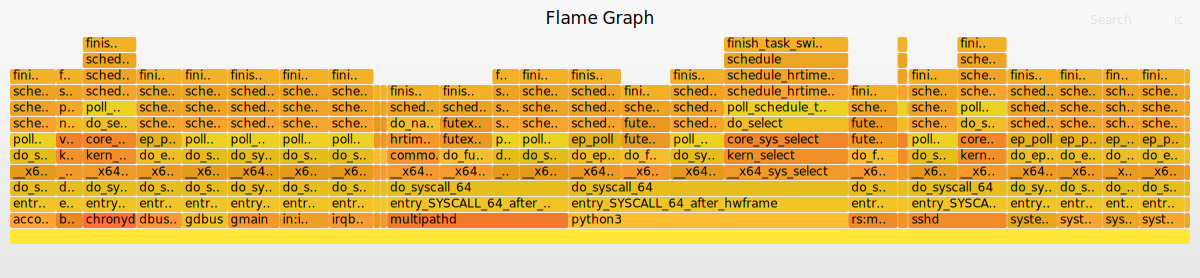

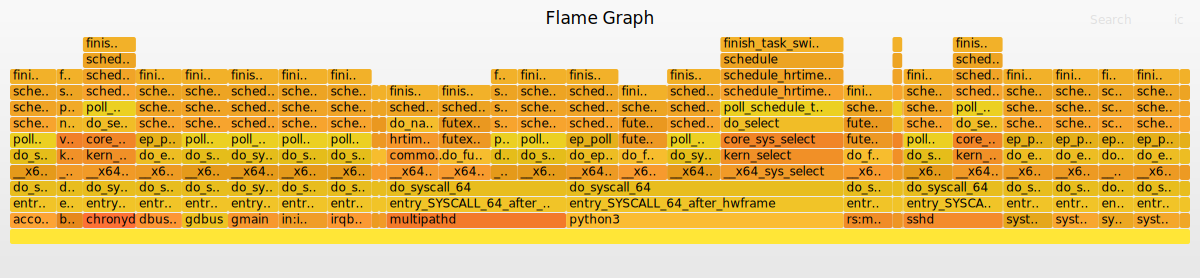

In [89]:
# summarize time spent by threads blocked and off CPU, showing stack traces to explain why threads are not running on a CPU
from IPython.display import SVG, display
display(SVG(filename='../ansible/.results/stl_dns_streams-rate_100kpps-offcputime.py.svg'))
display(SVG(filename='../ansible/.results/stl_dns_streams-rate_200kpps-offcputime.py.svg'))


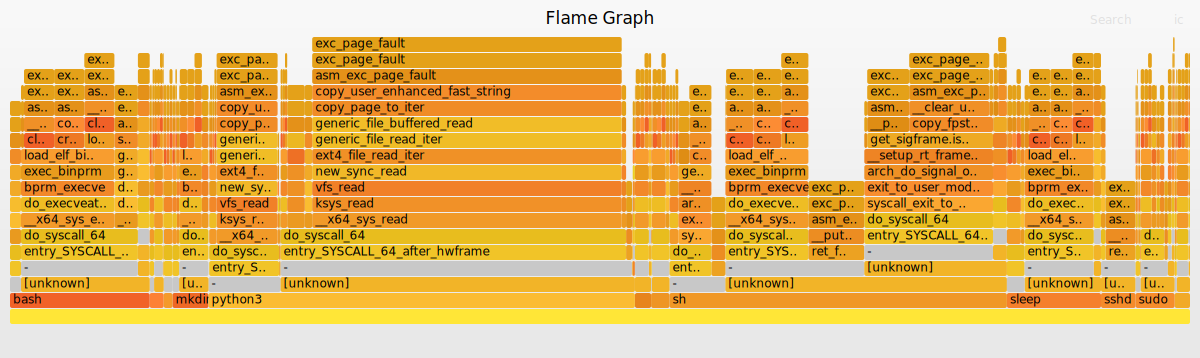

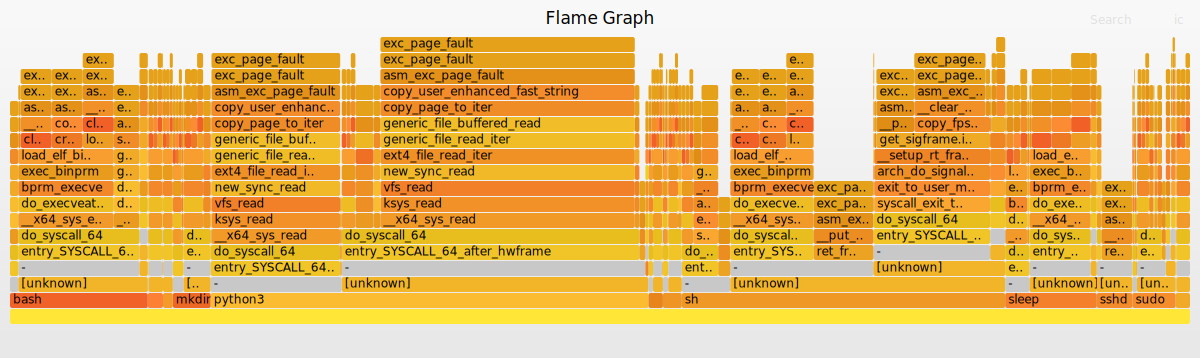

In [90]:
 # Tracing page faults can tell us code paths that first used it (mem) and triggered a page fault. These page faults cause RSS growth, so the stack traces can explain why a process is growing
 # /Users/tariromukute/Documents/personal/phd/dev/opengilan/ansible/.results/stl_dns_streams-rate_100kpps-stackcount.py.page_fault_kernel.svg
 # /Users/tariromukute/Documents/personal/phd/dev/opengilan/ansible/.results/stl_dns_streams-rate_200kpps-stackcount.py.page_fault_kernel.svg
display(SVG(filename='../ansible/.results/stl_dns_streams-rate_100kpps-stackcount.py.page_fault_kernel.svg'))
display(SVG(filename='../ansible/.results/stl_dns_streams-rate_200kpps-stackcount.py.page_fault_kernel.svg'))

In [11]:
df = spark.read.option("basePath", "folder/").json("folder/year=*/month=02/country=CN")
print(df.rdd.getNumPartitions())
df.show()

1
+--------+-------+-------------------+--------+----+-----+-------+
|   count|softirq|                 ts|val_type|year|month|country|
+--------+-------+-------------------+--------+----+-----+-------+
| 722.105|  block|2022-02-25 14:33:47|   usecs|2022|    2|     CN|
| 1675.31|  timer|2022-02-25 14:33:47|   usecs|2022|    2|     CN|
|2477.113|    rcu|2022-02-25 14:33:47|   usecs|2022|    2|     CN|
+--------+-------+-------------------+--------+----+-----+-------+



In [10]:
df = spark.read.option("basePath", "folder/").json(
"folder/year=*/month=*/country=CN")
# print(df.rdd.getNumPartitions())
df.show()

+--------+-------+-------------------+--------+----+-----+-------+
|   count|softirq|                 ts|val_type|year|month|country|
+--------+-------+-------------------+--------+----+-----+-------+
| 722.105|  block|2022-02-25 14:33:47|   usecs|2022|    2|     CN|
| 1675.31|  timer|2022-02-25 14:33:47|   usecs|2022|    2|     CN|
|2477.113|    rcu|2022-02-25 14:33:47|   usecs|2022|    2|     CN|
+--------+-------+-------------------+--------+----+-----+-------+

